In [1]:
"""
Implementation of Caenorhabditis Elegans Brain/Neuronal Dynamics using Spiking Neural Networks
 
Author: Aamir Faaiz <aamirfaaiz@outlook.com>
Date: April 2021
 
Instructions: Run this code block first
Note: Kernal will have to be resarted to clear all variables stored in memory
"""
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
from scipy.misc import derivative
from scipy import signal
from numba import jit
from numba import cuda, vectorize
import random
from copy import deepcopy
plt.style.use('default')

### Dynamics Model & Neuron Circuit for Contour Tracking

Schematic of the neural circuit for contour tracking. N1 is a temperature sensitive input neuron. N1 − N3 is a positive comparator, and N7−N8−N9 is a gradient detector. Similarly, N1−N2 is a complementary comparator, and N4 − N5 − N6 is a gradient detector. N6 and N9 control the deterministic turns, while N10 controls the random exploration.

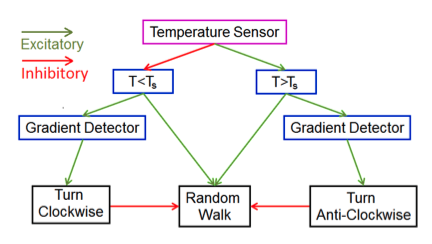

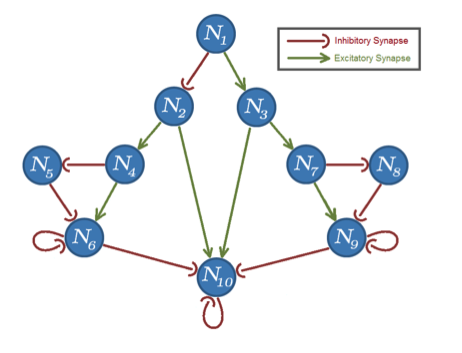

### Leaky Integrate and Fire
The dynamics of the membrane potential V (t), in the LIF neuron model is given by the equation:

$C\frac{dV(t)}{dt} = -g_L(V(t)-E_L)+I_{app}(t)$ [1]

Using Eulers method, we can approximate numerical solutions to the differential equation:

$V(t+\Delta t) = V(t) + \Delta t (\frac{dV}{dt})$

$V(t+\Delta t) = V(t) + \frac{\Delta t}{C} [-g_L(V(t)-E_L)+I_{app}(t)]$

In [2]:
#Functions
def simulateLIFRefrac(dt,I,C,gL,EL,VT,W,ker,Nk,I_bias,tref=0):
    '''Approximate LIF Neuron dynamics by Euler's method.

    Parameters
    ----------
    dt :number
       Euler time-step (ms)
       
    C,gL,EL,VT:number
        neuronal parameters
     
    I:1D NumPy array
        Input current (pA)
    
    W:1D NumPy array
        Synaptic Weight Strengths  - Connectivity Matrix
    
    ker:1D NumPy Array
        Current Kernal
    
    Ibias: NumPy Array
        Current Bias
    
    tref: number
        Refractory Period (ms)
    
    Returns
    -------
    V,Isyn :  NumPy array (mV), NumPy array (pA)
        Approximation for membrane potential computed by Euler's method.
    '''
    
    V=EL*np.ones((np.shape(I)[0],2*np.shape(I)[1])) #initialising V
    stim=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic stimulus
    Isyn=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic current 
    spike_instants = np.zeros(np.shape(I)[0]) #spike instants for neurons
    for n in range(0,np.shape(I)[1]-1):
        neuron_refractory = np.where(n>spike_instants+(tref/dt))
        if(np.size(neuron_refractory)>0):
            V[neuron_refractory,n+1] = V[neuron_refractory,n] + (dt/C)*(I[neuron_refractory,n]
                                            +Isyn[neuron_refractory,n] 
                                            +I_bias[neuron_refractory,n] 
                                            -gL*(V[neuron_refractory,n]-EL))
        else:
            V[:,n+1] = EL
        error_check=np.where(V[:,n+1]<EL)[0]
        if np.size(error_check)>0:V[error_check,n+1]=EL #Set to EL when V goes below EL
        check=np.where(V[:,n+1]>VT)[0]
        if np.size(check)>0:
            V[check,n+1]=EL
            V[check,n]=VT #Artificial Spike
            spike_instants[check] = n
            stim[check,n+1:n+1+Nk] += ker
            Isyn[:,n+1:] = 1000*np.matmul(W,stim[:,n+1:])
            
    return V,Isyn


def gradientDetect(dt,I,C,gL,EL,VT,ker,Nk,I_bias,tref,c,tau_a,d,w45,w46,w56_initial,w66,pcm=False):
    '''Gradient Detection 

    Parameters
    ----------
    dx :number
       Euler time-step (ms)
       
    C,gL,EL,VT:number
        neuronal parameters
     
    I:1D NumPy array
        Input current (pA)
    
    ker:1D NumPy Array
        Current Kernal
    
    Ibias: Number
        Neuron 5 Current Bias(pA)
    
    tref: number
        Refractory Period (ms)
    
    c,tau_a,d: number
        Weight Adaptation Parameters
    
    w45,w46,w56_initial,w66: number
        Synaptic Strengths
    pcm: Boolean
        Low Precission Weight Encoding
    
    Returns
    -------
    V,Isyn,w56_weights :  NumPy array (mV), NumPy array (pA), NumPy array
        
    '''
    W_gdetect = np.zeros((3,3))
    W_gdetect[1,0] = w45 
    W_gdetect[2,0] = w46
    W_gdetect[2,1] = w56_initial
    W_gdetect[2,2] = w66
    w56_weights=[]
    V=EL*np.ones((np.shape(I)[0],2*np.shape(I)[1])) #initialising V
    stim=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic stimulus
    Isyn=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic current 
    spike_instants = np.zeros(np.shape(I)[0]) #spike instants for neurons
    Ibias = np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising bias current 
    Ibias[1] = I_bias #Setting Neuron 5 bias current
    spike_instants = np.zeros(np.shape(I)[0]) #spike instants for neurons
    for n in range(0,np.shape(I)[1]-1):
        neuron_refractory = np.where(n>spike_instants+(tref/dt))
        if(np.size(neuron_refractory)>0):
            V[neuron_refractory,n+1] = V[neuron_refractory,n] +(dt/C)*(I[neuron_refractory,n]
                                            +Isyn[neuron_refractory,n] 
                                            + Ibias[neuron_refractory,n]
                                            -gL*(V[neuron_refractory,n]-EL))
        else:
            V[:,n+1] = EL
        error_check=np.where(V[:,n+1]<EL)[0]
        if np.size(error_check)>0:V[error_check,n+1]=EL #Set to EL when V goes below EL
        check=np.where(V[:,n+1]>VT)[0]
        if np.size(check)>0:
            V[check,n+1]=EL
            V[check,n]=VT #Artificial Spike
            spike_instants[check] = n
            stim[check,n+1:n+1+Nk] += ker
            Isyn[:,n+1:] = 1000*np.matmul(W_gdetect,stim[:,n+1:])
            #Checking if N5 has spiked
            if(V[1][n]==VT):
               if(pcm): W_gdetect[2,1] = pcm_weights(W_gdetect[2,1] + ((c/tau_a)+ ((d-W_gdetect[2,1])/tau_a))) 
               else: W_gdetect[2,1] = W_gdetect[2,1] + ((c/tau_a)+ ((d-W_gdetect[2,1])/tau_a))
            else:
                if(pcm): W_gdetect[2,1]+= pcm_weights(((d-W_gdetect[2,1])/tau_a))
                else: W_gdetect[2,1]+= ((d-W_gdetect[2,1])/tau_a)
        w56_weights.append(W_gdetect[2,1])
#         print(W_gdetect[2,1])
    return V,Isyn,w56_weights


def currentKernal(dT,tau1,tau2,kerlen):
    ''' Synaptic Current Kernel Generation
    Parameters
    ----------
    dT: number
        Time-step (ms)
    tau1, tau2: number
        Time Constants
    kerlen: number
        Time Span of Kernal (ms)
    Returns
    -------
    ker,Nk: Current Kernal, Number of Kernals
    '''
    # Obtaining kernel
    Nk = np.int_(kerlen/dT)
    xker = np.linspace(0, kerlen,Nk , endpoint=True)
    ker =  np.array(np.exp(-xker/tau1)-np.exp(-xker/tau2))
    return ker,Nk


def pcm_weights(w, precision=4, write_noise_stdv=0.1):
    ''' PCM Weights Generation
    Parameters
    ----------
    w:  NumPy Matrix
        Neuron Connectivity Matrix
    precision: number
        Number of precission bits for weights
    write_noise_stdv: number
        Standard deviation of weights
    Returns
    -------
    w_renorm: PCM Weights
    '''
    quant_max = 2**(precision-1) -1
    w_max = np.amax(np.abs(w))
    w_norm = w/w_max
    w_scaled = w_norm * quant_max
    w_round = np.round(w_scaled)
    w_clip = np.clip(w_round,-quant_max,quant_max)
    w_renorm = w_clip * w_max / quant_max

    if write_noise_stdv > 0.0:
        w_renorm = w_renorm + np.random.normal(0,1,np.shape(w)) * write_noise_stdv

    return w_renorm


def currentInputGen(T,Ts,alpha,beta):
    '''Temperature Input to Current Generation for Neuron 1
    
    Parameters
    ----------
    T: Temperature Input
    Ts: Set Temperature Point
    alpha,beta: constants
    
    returns: Current Input for Neuron 1(pA)
    '''
    return (alpha + (beta*(T-Ts)))

def currentGen(scale,num_pulses):
    ''''Current Generation with a varying pulse width

    Parameters
    ----------
    scale: number
        Factor to increase pulse width by
    num_pulses: number
        Number of pulses to generate
    Returns
    -------
    Iinp: 1D NumPy Array Current Matrix
    '''
    Iinp=np.zeros(1)
    ton = scale*(np.arange(num_pulses)+1)
    for n in range(0,len(ton)):
        Iinp = np.hstack([Iinp, 2700*np.ones(ton[n])]) 
        Iinp = np.hstack([Iinp, np.zeros(400)])
    return Iinp
    

def plotter(x,y1,title,yaxlabel,y1label=None,y2=None,y2label=None,usedark=False):
    '''Graph Plotting

    Parameters
    ----------
    x:1D NumPy array
       NumPy array to be used as the x-axis data
       
   y1,y2:1D NumPy array
        NumPy array to be used as the y-axis data
     
       
    yaxlabel:String
        Y axis label
    
    y1label,y2label:String
        Legend Labels
    
     title:String
         Graph title
         
    '''
    plt.style.use('dark_background') if usedark else plt.style.use('default')
    plt.figure(figsize=(10,5)) #Customisable size
    plt.rcParams.update({'font.size': 15})
    plt.grid(True)
    plt.plot(x,y1,'g-', label = y1label)
    if(y2 is not None):plt.plot(x,y2,'r-', label = y2label),plt.legend()
    plt.title(title)
    plt.xlabel("Time/ms")
    plt.ylabel(yaxlabel)
    plt.show()

### Saturating Current of LIF Neuron

Stimulating LIF Neuron with input current ranging from 2.4nA to 100nA and measuring spike frequency response

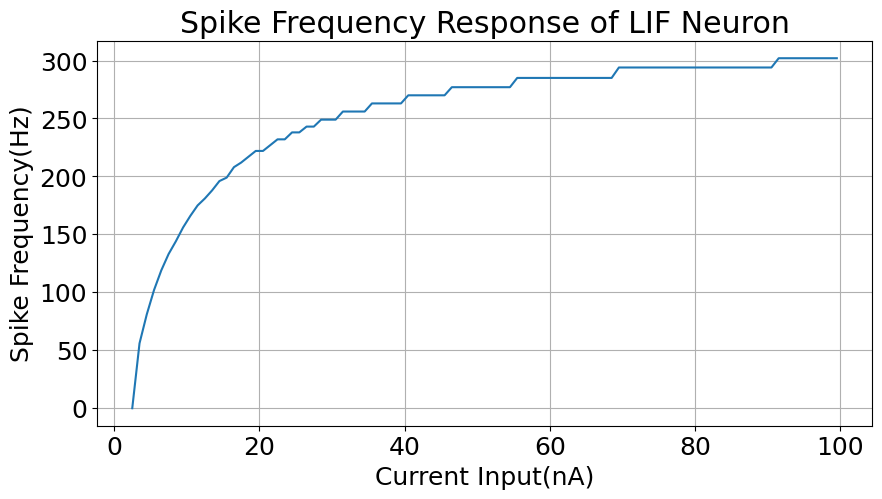

In [3]:
#Saturation Point of LIF Neuron

#Neuron parameters for simulation
C = 300 #Membrane Capacitance(pF)
gL = 30 #Membrane Leak Conductance(nS)
EL = -70 #Resting Potential(mV)
VT = 20  #Resting Potential(mV)

def LIF(dT,I,C,gL,EL,VT,tref):
    V = EL*np.ones((np.shape(I)))
    #iterating in the temporal dimension
    spike_instant = 0
    for n in (range((np.shape(I))[1]-1)):
        if(n>spike_instant+(tref/dT)):
            V[:,n+1] = V[:,n] + (dT/C) * (-gL*(V[:,n]-EL)+I[:,n])
        else:
            V[:,n+1] = EL
        check=np.where(V[:,n+1]>VT)[0]
        if np.size(check)>0:
            V[check,n+1]=EL
            spike_instant = n
            V[check,n]= VT #Artificial Spike
    return V

currents = np.arange(2500,100000,1000) #Simulating input current ranging from 2500pA to 100000pA
T = 1000 #Simulation Time (ms)
dt = 0.1 #Euler Time Step(ms)
tref = 3 #Refractory Period(ms)
iter = int(T/dt) #Total number of time-steps
frequencies = []
for i in range(len(currents)):
    Iinp = currents[i]*np.ones(iter)
    Iinp = np.reshape(Iinp,(1,iter))
    Vmem = LIF(dt,Iinp,C,gL,EL,VT,tref)
    # Estimating Spike Frequency Response
    spike_count = np.shape(np.where(Vmem[0] == VT))[1]
    frequencies.append(spike_count)
    
#Plotting 
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 18})
plt.plot(0.001*currents,frequencies) 
plt.title("Spike Frequency Response of LIF Neuron")
plt.xlabel("Current Input(nA)")
plt.ylabel("Spike Frequency(Hz)")
plt.grid()
plt.show()

### PCM Weights Demonstration


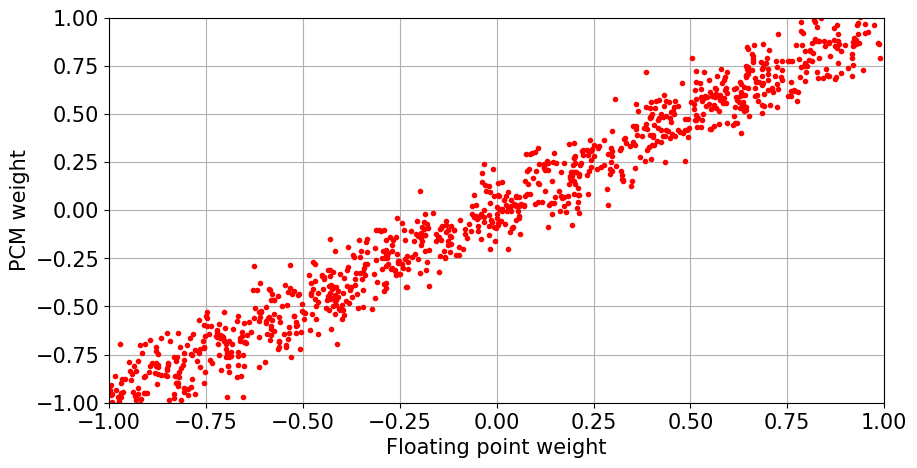

In [4]:
a=-1+2*np.random.random_sample((1000, 1))
b=pcm_weights(a)
plt.style.use('default') 
f=plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.plot(a ,b, 'r.',)

plt.xlabel('Floating point weight')
plt.ylabel('PCM weight')
plt.axis([-1,1,-1,1])
plt.show(block = False)

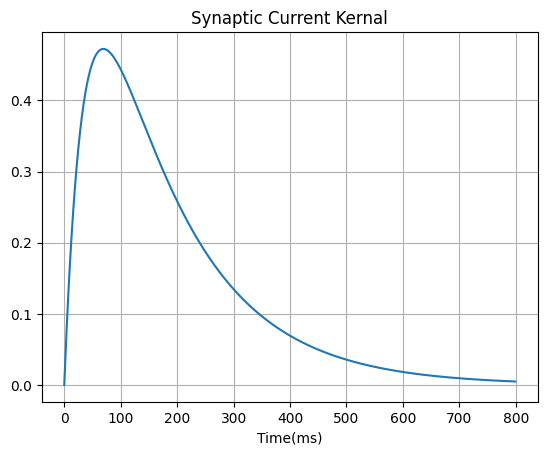

In [5]:
#Neuron Parameters
C = 300 #Membrane Capacitance(pF)
gL = 30 #Membrane Leak Conductance(nS)
EL = -70 #Resting Potential(mV)
VT = 20  #Resting Potential(mV)
dt = 0.1 #Euler Time Step(ms)
# Obtaining kernel
kerlen = 80
tau1 = 15 #Time Constant for Kernal Generation(ms)
tau2 = tau1/4 #Time Constant for Kernal Generation(ms)
ker,Nk = currentKernal(dt,tau1,tau2,kerlen)
plt.rcParams.update({'font.size': 10})
plt.plot(ker)
plt.title("Synaptic Current Kernal")
plt.xlabel("Time(ms)")
plt.grid()

### Experimenting with Temperature Comparators

We need two comparators:
1) Negative Comparator: $T<T_s$ Detection  
2) Positive Comparator: $T>T_s$ Detection

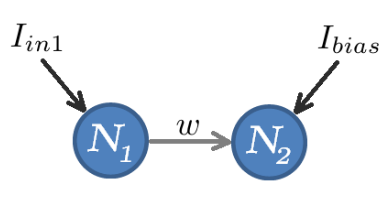

A complementary comparator (i.e., a network that
produces a proportional spike response for deviations of
local temperature below the set-point) can be realized by
making w negative and $I_{bias}$ positive.

In [6]:
def comparatorTests(threshold_temp,temperatures,alpha,beta,I_bias,comparator_weights,pcm=False):
    ''' Spike frequency response from comparator with varying parameters
     Parameters
    ----------
    threshold_temp: Number
        Threshold temperature
        
    temperatures: 1D NumPy Array
        Temperature range for simulation
        
    alpha,beta: Number
        Constants for Input Current Generation
        
    bias_currents: NumPy Matrix
        Bias Currents for simulation
        
    comparator_weights: NumPy Matrix
        Comparator Weights for simulation
    
    pcm: Boolean 
        Clone to PCM
    '''
    T = 1000 #Total time of simulation(ms)
    dt = 0.1 #Euler Time-Step(ms)
    iter = int(T/dt)
    Numneurons = 2
    tref = 3 #Neuron Refractory Period(ms)
    frequencies = []
    for i in range(len(comparator_weights)):
        spike_frequency = []
        for t in range(len(temperatures)):
            Temp = temperatures[t]*np.ones(iter)
            Iinp = currentInputGen(Temp,threshold_temp,alpha,beta) #Set Threshold Temperature to 20C
            I = np.vstack((Iinp,np.zeros((Numneurons-1,np.shape(Iinp)[0]))))
            t = dt*(np.arange(len(I[1])))
            if(pcm): Vmem1,Isyn1 = simulateLIFRefrac(dt,I,C,gL,EL,VT,pcm_weights(comparator_weights[i]),ker,Nk,I_bias[i],tref)#Simulate
            else: Vmem1,Isyn1 = simulateLIFRefrac(dt,I,C,gL,EL,VT,comparator_weights[i],ker,Nk,I_bias[i],tref)#Simulate
            # Estimating Spike Frequency
            spike_count = np.shape(np.where(Vmem1[1,0:np.shape(I)[1]] == VT))[1]
            spike_frequency.append(spike_count)
        frequencies.append(spike_frequency)
    return frequencies

### Positive Comparator

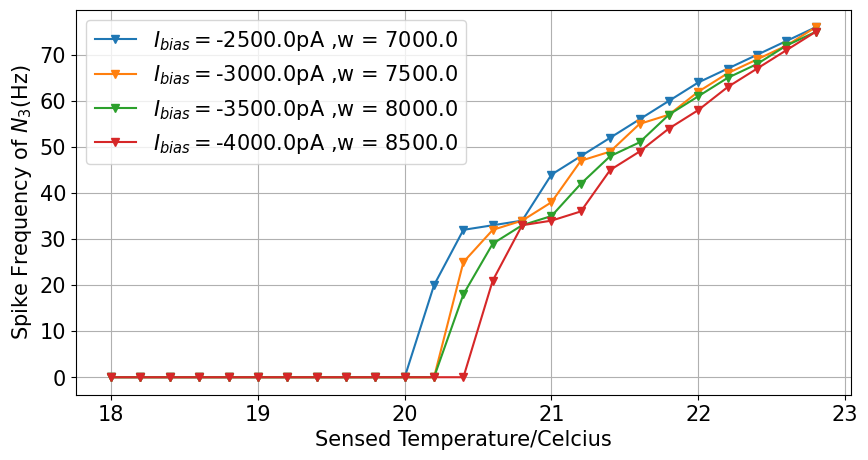

In [7]:
#Setting up bias currents for simulations
T=1000 
dT=.1
iter=int(T/dT)
I_bias = np.zeros((4,2,iter))
I_bias[0][1] = -2500
I_bias[1][1] = -3000
I_bias[2][1] = -3500
I_bias[3][1] = -4000

#Setting up weights for simulations
comparator_weights = np.ones((4,2,2))
comparator_weights[0] = [[0,0],
                        [7.0,0]]
comparator_weights[1] = [[0,0],
                        [7.50,0]]
comparator_weights[2] = [[0,0],
                        [8.0,0]]
comparator_weights[3] = [[0,0],
                        [8.5,0]]
#Temperature range for simulations
temperatures = np.arange(18,23,0.2)
threshold_temp = 20 #Celcius
alpha = 3750 #pA
beta  = 350  #pA/K
positive_frequency_response = comparatorTests(threshold_temp,temperatures,alpha,beta,I_bias,comparator_weights)
#Plotting 
plt.style.use('default')
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 15})
for i in range(len(positive_frequency_response)):
    plt.plot(temperatures,positive_frequency_response[i], label = "$I_{bias} = $" + str(I_bias[i][1][0]) + "pA"
                + " ,w = " + str(1000*comparator_weights[i][1][0]), marker = "v")
plt.legend()
# plt.title("Spike Frequency Response of Positive Comparator")
plt.xlabel("Sensed Temperature/Celcius")
plt.ylabel("Spike Frequency of $N_3$(Hz)")
plt.grid(True)
plt.show()

### Positive Comparator with Low Precission Weights

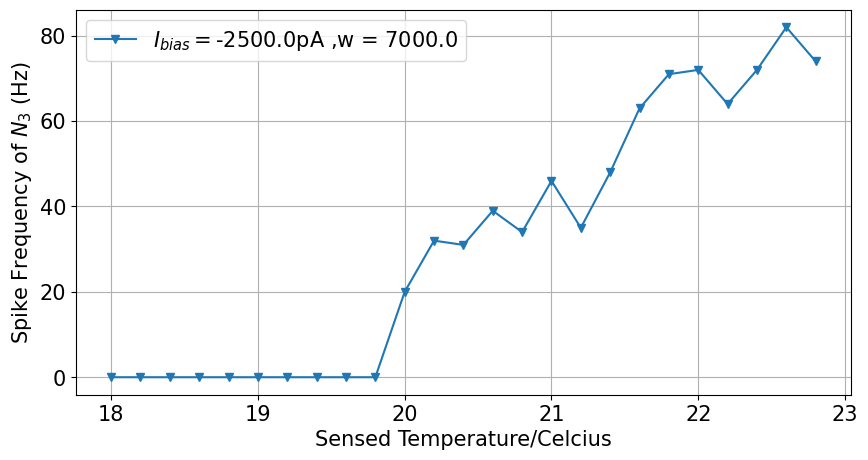

In [8]:
#Using Optimal Parameter Solution and simulation with PCM Weights
#Setting up bias currents for simulations
positive_comparator_bias = np.zeros((1,2,iter))
positive_comparator_bias[0][1] = -2500

#Setting up weights for simulations
positive_comparator_weight = np.ones((1,2,2))
positive_comparator_weight[0] = [[0,0],
                                 [7.0,0]]

positive_pcm_frequency_response = comparatorTests(20,temperatures,alpha,beta,positive_comparator_bias,positive_comparator_weight,True)

#Plotting 
plt.style.use('default')
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 15})
plt.plot(temperatures,positive_pcm_frequency_response[0], label = "$I_{bias} = $" + str(positive_comparator_bias[0][1][0]) + "pA"
            + " ,w = " + str(1000*positive_comparator_weight[0][1][0]), marker = "v")


plt.legend()
# plt.title("Spike Frequency Response of Positive Comparator with 4bit PCM Weights")
plt.xlabel("Sensed Temperature/Celcius")
plt.ylabel("Spike Frequency of $N_3$ (Hz)")
plt.grid(True)
plt.show()

### Negative Comparator

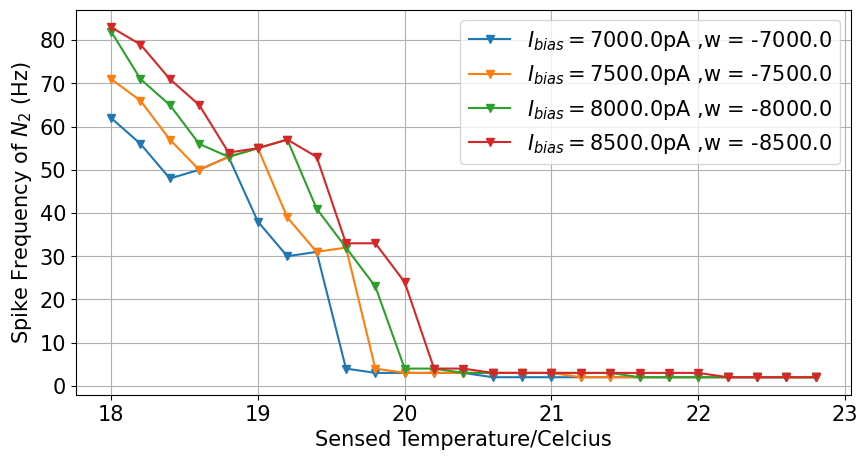

In [9]:
#Setting up bias currents for simulations
I_bias = np.zeros((4,2,iter))
I_bias[0][1] = 9000
I_bias[1][1] = 9500
I_bias[2][1] = 10000
I_bias[3][1] = 10500

I_bias[0][1] = 7000
I_bias[1][1] = 7500
I_bias[2][1] = 8000
I_bias[3][1] = 8500


#Setting up weights for simulations
negative_comparator_weights = np.ones((4,2,2))
negative_comparator_weights[0] = [[0,0],[-7.0,0]]
negative_comparator_weights[1] = [[0,0],[-7.50,0]]
negative_comparator_weights[2] = [[0,0],[-8.0,0]]
negative_comparator_weights[3] = [[0,0],[-8.5,0]]
#Temperature range for simulations
temperatures = np.arange(18,23,0.2)
alpha = 3750 #pA
beta = 350 #pA/K
threshold_temp = 20 #Celcius
negative_frequency_response = comparatorTests(threshold_temp,temperatures,alpha,beta,I_bias,negative_comparator_weights)

#Plotting 
plt.style.use('default')
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 15})
for i in range(len(positive_frequency_response)):
    plt.plot(temperatures,negative_frequency_response[i], label = "$I_{bias} = $" + str(I_bias[i][1][0]) + "pA"
                + " ,w = " + str(1000*negative_comparator_weights[i][1][0]), marker = "v")
plt.legend()
# plt.title("Spike Frequency Response of Negative Comparator")
plt.xlabel("Sensed Temperature/Celcius")
plt.ylabel("Spike Frequency of $N_2$ (Hz)")
plt.grid(True)
plt.show()

### Negative Comparator with Low Precission Weights

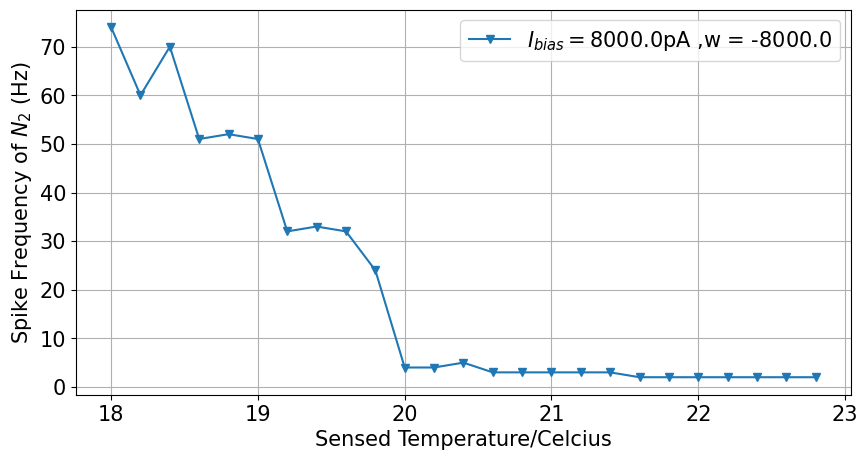

In [10]:
#Using Optimal Parameter Solution and simulation with PCM Weights
#Setting up bias currents for simulations
negative_comparator_bias = np.zeros((1,2,iter))
negative_comparator_bias[0][1] = 8000

#Setting up weights for simulations
negative_comparator_weight = np.ones((1,2,2))
negative_comparator_weight[0] = [[0,0],
                                 [-8.0,0]]

negative_pcm_frequency_response = comparatorTests(20,temperatures,alpha,beta,negative_comparator_bias,negative_comparator_weight,True)
#Plotting 
plt.style.use('default')
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 15})
plt.plot(temperatures,negative_pcm_frequency_response[0], label = "$I_{bias} = $" + str(negative_comparator_bias[0][1][0]) + "pA"
            + " ,w = " + str(1000*negative_comparator_weight[0][1][0]), marker = "v")
plt.legend()
# plt.title("Spike Frequency Response of Comparator with 4bit PCM Weights")
plt.xlabel("Sensed Temperature/Celcius")
plt.ylabel("Spike Frequency of $N_2$ (Hz)")
plt.grid(True)
plt.show()

### Gradient Detector

Operation required to detect temperature gradients: 

$f(t+dt)-f(t)$

The Neuron Ciruit below is the design choice for the gradient detector operation. The excitatory synapse between N4-N6 essentially computes $f(t+dt)$ and the connectivity $N_{4}-N_{5}-N_{6}$ essentially computes the $-f(t)$ operation. 

The network should only send out a spike when there is a gradient detected. Therefore, there has to be some sort of competition between the current that is comming in both pathways, and they should be trying  to cancel each other out, such that only when there is a change in N4-N6, a spike response is created.

$w_{56}$ should adapt in such a way that the net current that is comming into $N_6$ should be zero.

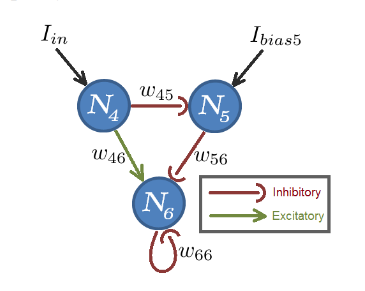



### Memoryless Synaptic Strength Adaptation
Modifying the strength of each synapse using the following rule:

$\Delta w_{56} = \frac{c}{\tau_a}\delta(t-t^{N_5})+\frac{d-w_{56}}{\tau_a}\Delta t$ 

$t^{N5}$ denotes the instants where neuron $N_5$ has spiked


### 30 Second Simulation (Gradient Detector Test)

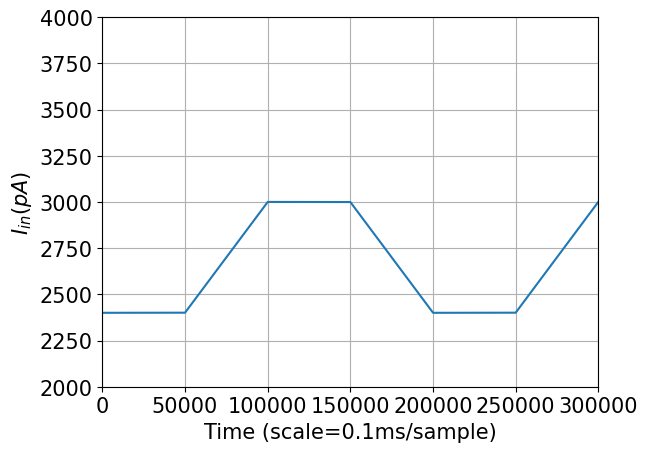

In [11]:
#Generate Current Input for gradient detection simulation
T = 30000 #ms
dT = 0.1
iter=int(T/dT) #Number of timesteps
gradients = 6 #Number of gradients for simulation
gradient_period = int(iter/gradients) #dt for gradient switching
x_stop = gradient_period*dT

# 6 gradients for simulation:
#     1. Constant for t1
#     2. Positive for t2
#     3. Constant for t3
#     4. Negative for t4
#     5. Constant for t5
#     6. Positive for t6

#Initialising Currents 
lower_bound = 2400 #pA
upper_bound = 3000 #pA
positive_gradient = ((upper_bound-lower_bound)/(dT*gradient_period))
negative_gradient = -positive_gradient

Iinp = np.zeros(iter)
Iinp[:gradient_period] = lower_bound
Iinp[gradient_period:2*gradient_period] = (positive_gradient*np.linspace(0,x_stop,gradient_period))+lower_bound
Iinp[2*gradient_period:3*gradient_period] = upper_bound
Iinp[3*gradient_period:4*gradient_period] = (negative_gradient*np.linspace(0,x_stop,gradient_period))+upper_bound
Iinp[4*gradient_period:5*gradient_period] = lower_bound
Iinp[5*gradient_period:6*gradient_period] = (positive_gradient*np.linspace(0,x_stop,gradient_period))+lower_bound
I1= np.vstack((Iinp,np.zeros((3-1,np.shape(Iinp)[0]))))
plt.plot(Iinp)
plt.ylabel("$I_{in}(pA)$")
plt.xlabel("Time (scale="+str(dT)+"ms/sample)")
plt.axis([0, iter,2000,4000])
plt.grid()

### Genetic Algorithm for weight adaptation tuning


In [ ]:
# Genetic algorithm
'''
Ranges:

c:  5 to  15 ,
d: -0.5 to  -10,
tau_a: 5 to 30

#Weights!
w45: -0.5 to -10
w46: 5 to 15
w56_initial: -0.5 to -10
w66 = -2 to -6 #N6-N6 weight for stability

I_bias: 20000 to 8000
'''
POPULATION_SIZE = 100
N_ITERS = 10

def get_rand(min, max):
 return round(random.uniform(min, max),1)


def get_spikes_n6(vo):
  # vn6 = vo[:-1]
  return np.where(vo[2]>=VT)[0]


def score(c, d, tau_a, w45, w46, w56_initial, w66,I_bias):
  Vmem1,Isyn1,w56_weights = gradientDetect(dT,I1,C,gL,EL,VT,ker,Nk,I_bias,tref,c,tau_a,d,w45,w46,w56_initial,w66)
  sp = get_spikes_n6(Vmem1)

  # wrong_spikes = [x for x in sp if (x < 2000 or x > 4000)]
  # right_spikes = [x for x in sp if (x >= 2000 and x <= 4000)]

  wrong_spikes = [x for x in sp if (x < 50000 or (x > 100000 and x < 250000))]
  right_spikes = [x for x in sp if (x >= 50000 and x <= 100000) or (x >= 250000 and x<=300000)]

  score = 100 + 12 * len(wrong_spikes)  - 12 * len(right_spikes)
  score += -(50 if len(wrong_spikes) < 1 else 0) + (50 if len(right_spikes) < 1 else 0)

  if score < 0:
    score = 0

  return score
#   return 100 + 9 * len(wrong_spikes)  - 12 * len(right_spikes) - (50 if len(wrong_spikes) < 1 else 0) + (50 if len(right_spikes) < 1 else 0)


def selection(pop, scores, k=3):
  # first random selection
	selection_ix = np.random.randint(len(pop))
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]


def crossover(p1, p2, r_cross):
  child1, child2 = deepcopy(p1), deepcopy(p2)
  if get_rand(0,1) < r_cross:
    print('[] Crossover happening with: ' + str(child1) + ' and ' + str(child2))
    c_pt = get_rand(0, abs(p1[0] - p2[0]))
    d_pt = get_rand(0, abs(p1[1] - p2[1]))
    tau_pt = get_rand(0, abs(p1[2] - p2[2]))
    w45_pt = get_rand(0, abs(p1[3] - p2[3]))
    w46_pt = get_rand(0, abs(p1[4] - p2[4]))
    w56_initial_pt = get_rand(0, abs(p1[5] - p2[5]))
    w66_pt = get_rand(0, abs(p1[6] - p2[6]))
    I_bias_pt = get_rand(0, abs(p1[7] - p2[7]))

    c1 = min(p1[0], p2[0]) + c_pt
    c2 = max(p1[0], p2[0]) - c_pt

    d1 = min(p1[1], p2[1]) + d_pt
    d2 = max(p1[1], p2[1]) - d_pt

    tau1 = min(p1[2], p2[2]) + tau_pt
    tau2 = max(p1[2], p2[2]) - tau_pt

    w45_1 = min(p1[3], p2[3]) + w45_pt
    w45_2 = max(p1[3], p2[3]) - w45_pt

    w46_1 = min(p1[4], p2[4]) + w46_pt
    w46_2 = max(p1[4], p2[4]) - w46_pt

    w56_initial_1 = min(p1[5], p2[5]) + w56_initial_pt
    w56_initial_2 = max(p1[5], p2[5]) - w56_initial_pt

    w66_1 = min(p1[6], p2[6]) + w66_pt
    w66_2 = max(p1[6], p2[6]) - w66_pt

    I_bias_1 = p1[7] + I_bias_pt
    I_bias_2 = p2[7] - I_bias_pt

    child1 = (c1, d1, tau1, w45_1, w46_1, w56_initial_1, w66_1,I_bias_1)
    child2 = (c2, d2, tau2, w45_2, w46_2, w56_initial_2, w66_2,I_bias_2)
  return [child1, child2]

# mutation operato
def mutation(body, r_mut):
  for i in range(len(body)):
    # check for a mutation
    if get_rand(0, 1) < r_mut:
      print('[] Mutation occuring for: ' + str(body))
      # flip the bit
      new_val = body[i]
      if i == 0:
        new_val = get_rand(5, 15)
      elif i == 1:
        new_val = get_rand(-0.5, -10)
      elif i == 2:
        new_val = get_rand(5, 30)
      elif i == 3:
        new_val = get_rand(-5, -0.5)
      elif i == 4:
        new_val = get_rand(5, 15)
      elif i == 5:
        new_val = get_rand(-10, -0.5)
      elif i == 6:
        new_val = get_rand(-6, -2)
      elif i == 7:
        new_val = get_rand(2000,8000)
      body = list(body)
      body[i] = new_val
      body = tuple(body)
      print('[] New value is: ' + str(body))

# @vectorize(target="parallel")
def genetic_algo():
  r_cross = 0.35
  r_mut = 0.05

  # Returns population of tuples of the form:
  #(c, d, tau_a,w45,w46,w56_initial,w66,Ibias)
  # population = [(get_rand(5, 20), get_rand(-10, -0.5), get_rand(5, 30), get_rand(-10, -0.5), get_rand(5, 15), get_rand(-10, -0.5), get_rand(-6, -2),get_rand(2000,6000)) for _ in range(POPULATION_SIZE)]
  population = [(get_rand(5, 15), get_rand(-10, -0.5), get_rand(5, 30), get_rand(-5, -0.5), get_rand(5, 15), get_rand(-10, -0.5), get_rand(-6, -2),get_rand(2000,8000)) for _ in range(POPULATION_SIZE)]
  n_pop = len(population)

  best, best_eval = 0, score(*population[0])

  for gen in range(N_ITERS):
    print('Populations:')
    print(population)

    # Get scores
    scores = [score(*c) for c in population]

    print('Scores:')
    print(scores)

    # Check for new best scores
    for i in range(n_pop):
      if scores[i] < best_eval:
        best, best_eval = population[i], scores[i]
        print(">%d, new best f(%s) = %.3f" % (gen,  population[i], scores[i]))

    # Perform tournament
    selected = [selection(population, scores) for _ in range(POPULATION_SIZE)]

    children = list()
    for i in range(0, n_pop, 2):
      # get selected parents in pairs
      try:
        p1, p2 = selected[i], selected[i+1]
      except IndexError:
        if p1 is None:
          break
        children.append(p1)

      # crossover and mutation
      for c in crossover(p1, p2, r_cross):
        # mutation
        mutation(c, r_mut)
        # store for next generation
        children.append(c)
    population = children
  print('Best is:')
  print(best)
    
genetic_algo()

In [12]:
#Simulation
Numneurons = 3 #N4-N5-N6
I_bias = 2800
tref = 3 #Refractory Period(ms)
#Gradient Detector Parameters
c,d,tau_a,w45,w46,w56_initial,w66,I_bias = (8.365406866817512, -5.7172469083885336, 22.993129497338796, -1.868965162763052, 6.8399624018718255, -2.7420209289913564, -4.202035141656892, 3811.0644999147507)
I1= np.vstack((Iinp,np.zeros((Numneurons-1,np.shape(Iinp)[0]))))
Vmem1,Isyn1,w56_weights = gradientDetect(dT,I1,C,gL,EL,VT,ker,Nk,I_bias,tref,c,tau_a,d,w45,w46,w56_initial,w66)#Simulate with weight adaptation

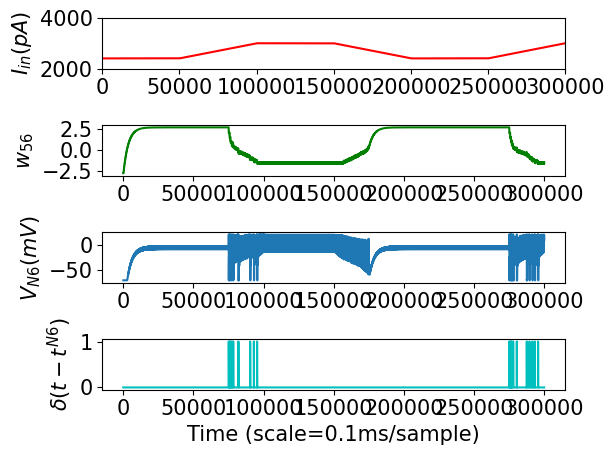

In [13]:
#6s Simulation
#Plotting
plt.figure(1)
plt.subplot(411)
# plt.title("Gradient Detetor Simulation")
plt.plot(Iinp,'r')
plt.axis([0, iter,2000,4000])
plt.ylabel("$I_{in}(pA)$")

plt.subplot(412)
plt.plot(w56_weights,'g')
plt.ylabel("$w_{56}$")

plt.subplot(413)
plt.plot(Vmem1[2][:iter])
plt.ylabel("$V_{N6}(mV)$")

spike_times = dT*np.where(Vmem1[2,0:np.shape(I1)[1]]==VT)[0] #Spike times of N6
stim = np.zeros(iter)
#Creating delta function for N6 spike times
for i in range(len(spike_times)):stim[(int(spike_times[i]/dT))] = 1

#Plotting delta function for N6 spikes for clarity
plt.subplot(414)
plt.plot(stim,'c')
plt.ylabel("$\delta(t-t^{N6})$")
plt.xlabel("Time (scale="+str(dT)+"ms/sample)")

plt.tight_layout()
plt.show()